<a href="https://colab.research.google.com/github/JairAlbertoHuertaDiaz45/Simulaci-n-II/blob/main/Modelo_Cine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Huerta Díaz Jair Alberto

**El sistema se modela como un conjunto de líneas de espera con múltiples servidores, donde los clientes pueden seguir rutas paralelas para la compra de boletos y el consumo de dulcería, y posteriormente convergen en el ingreso a las salas de cine. El objetivo del modelo es analizar el comportamiento de las colas y los tiempos de espera, así como evaluar el desempeño del sistema bajo una demanda variable a lo largo del día**

In [90]:
!pip install simpy
import simpy
import random
import statistics
import math
import matplotlib.pyplot as plt

Como sabemos en la actualidad un cine opera normalmente en un tiempo aproximadamente de 8 horas al día, lo que da un total de 480 minutos.

Adicional a esto, dependiendo de la demanda por día o incluso por hora, en promedio en una cine, tenemos al menos 4 taquillas abiertas, 5 en dulceria y en promedio 6 salas (este último, depende del tamaño del cine y las peliculas estrenadas)

In [91]:
HORAS_APERTURA = 8
TIEMPO_SIMULACION = HORAS_APERTURA * 60  # minutos

# Recursos
TAQUILLAS = 4
DULCERIA = 5
SALAS = 6

Se crean las listas para almacenar tiempos de cada cliente, y se utilizan para calcular promedios al final de la simulación.

In [92]:
tiempo_sistema = []
espera_taquilla = []
espera_dulceria = []
espera_sala = []

# Para gráficas
tiempo = []
cola_taquilla = []
cola_dulceria = []
cola_sala = []

Esta función modela la variación de clientes a lo largo del día, como bien sabemos cuando es la apertura del mismo cine, la demanda no es la misma, va en aumento conforme pasa el tiempo.

In [93]:
def tasa_llegada(env):
    if env.now < 180:        # primeras 3 horas
        return 1 / 2
    elif env.now < 360:      # horas pico
        return 1 / 0.5
    else:                    # últimas horas
        return 1 / 3

Esta función, representa el recorrido completo de un cliente dentro del cine, registrando el tiempo de llegada al sistema.

Analizando la probabilidad con la que este podria llegar a pasar al servicio de Taquilla para adquirir sus boletos o incluso a la Dulceria, el cuál sigue una distribución triangular.

In [94]:
def cliente(env, nombre, taquilla, dulceria, salas):
    llegada = env.now

    # ---- Compra de boletos ----
    if random.random() < 0.6:
        with taquilla.request() as req:
            t0 = env.now
            yield req
            espera_taquilla.append(env.now - t0)
            yield env.timeout(random.triangular(2, 4, 6))
    else:
        yield env.timeout(1)

    # ---- Dulcería ----
    if random.random() < 0.7:
        with dulceria.request() as req:
            t0 = env.now
            yield req
            espera_dulceria.append(env.now - t0)
            yield env.timeout(random.triangular(3, 5, 8))

    # ---- Ingreso a sala ----
    with salas.request() as req:
        t0 = env.now
        yield req
        #print(f"{nombre}ENTRA A LA SALA en t={env.now:.1f}")
        espera_sala.append(env.now - t0)
        yield env.timeout(1)

    tiempo_sistema.append(env.now - llegada)

Genera clientes de acuerdo con una distribución exponencial. La generación se detiene al cerrar el cine.

In [95]:
def llegadas(env, taquilla, dulceria, salas):
    i = 0
    while env.now < TIEMPO_SIMULACION:
        yield env.timeout(random.expovariate(tasa_llegada(env)))
        i += 1
        env.process(cliente(env, f"Cliente {i}", taquilla, dulceria, salas))

Registra el tamaño de las colas, cada 5 minutos

In [96]:
def monitoreo(env, taquilla, dulceria, salas):
    while True:
        tiempo.append(env.now)
        cola_taquilla.append(len(taquilla.queue))
        cola_dulceria.append(len(dulceria.queue))
        cola_sala.append(len(salas.queue))
        yield env.timeout(5)

Nuestra el estado del sistema durante la simulación, además de que indica cuantos clientes están siendo atendidos.

In [97]:
def animacion(env, taquilla, dulceria, salas):
    while True:
        print(f"T={env.now:6.1f} | "
              f"Taquilla:{len(taquilla.queue)} | "
              f"Dulcería:{len(dulceria.queue)} | "
              f"Salas:{len(salas.queue)}")
        yield env.timeout(15)

Ejecutamos el entorno de la simulación, recursos con su capacidad correspondiente, procesos del modelo y sobre todo, sólo se va a ejecutar por el tiempo correspondiente, en este caso 8 horas o 480 minutos.

In [98]:
env = simpy.Environment()

taquilla = simpy.Resource(env, capacity=TAQUILLAS)
dulceria = simpy.Resource(env, capacity=DULCERIA)
salas = simpy.Resource(env, capacity=SALAS)

env.process(llegadas(env, taquilla, dulceria, salas))
env.process(monitoreo(env, taquilla, dulceria, salas))
env.process(animacion(env, taquilla, dulceria, salas))

env.run(until=TIEMPO_SIMULACION)

T=   0.0 | Taquilla:0 | Dulcería:0 | Salas:0
T=  15.0 | Taquilla:0 | Dulcería:0 | Salas:0
T=  30.0 | Taquilla:0 | Dulcería:0 | Salas:0
T=  45.0 | Taquilla:0 | Dulcería:0 | Salas:0
T=  60.0 | Taquilla:0 | Dulcería:0 | Salas:0
T=  75.0 | Taquilla:0 | Dulcería:0 | Salas:0
T=  90.0 | Taquilla:0 | Dulcería:0 | Salas:0
T= 105.0 | Taquilla:0 | Dulcería:0 | Salas:0
T= 120.0 | Taquilla:0 | Dulcería:0 | Salas:0
T= 135.0 | Taquilla:0 | Dulcería:0 | Salas:0
T= 150.0 | Taquilla:0 | Dulcería:0 | Salas:0
T= 165.0 | Taquilla:0 | Dulcería:0 | Salas:0
T= 180.0 | Taquilla:0 | Dulcería:0 | Salas:0
T= 195.0 | Taquilla:3 | Dulcería:2 | Salas:0
T= 210.0 | Taquilla:4 | Dulcería:14 | Salas:0
T= 225.0 | Taquilla:7 | Dulcería:20 | Salas:0
T= 240.0 | Taquilla:8 | Dulcería:24 | Salas:0
T= 255.0 | Taquilla:14 | Dulcería:32 | Salas:0
T= 270.0 | Taquilla:18 | Dulcería:32 | Salas:0
T= 285.0 | Taquilla:25 | Dulcería:36 | Salas:0
T= 300.0 | Taquilla:35 | Dulcería:42 | Salas:0
T= 315.0 | Taquilla:34 | Dulcería:47 | Salas

In [99]:
print("\nRESULTADOS DEL SISTEMA\n")

print(f"Clientes atendidos: {len(tiempo_sistema)}")
print(f"Tiempo promedio en el sistema: {statistics.mean(tiempo_sistema):.2f} min")
print(f"Espera promedio en taquilla: {statistics.mean(espera_taquilla):.2f} min")
print(f"Espera promedio en dulcería: {statistics.mean(espera_dulceria):.2f} min")
print(f"Espera promedio para sala: {statistics.mean(espera_sala):.1f} min")


RESULTADOS DEL SISTEMA

Clientes atendidos: 485
Tiempo promedio en el sistema: 39.98 min
Espera promedio en taquilla: 18.08 min
Espera promedio en dulcería: 32.25 min
Espera promedio para sala: 0.0 min


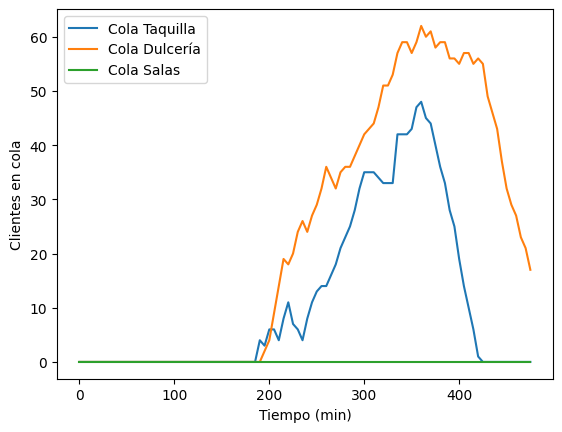

In [100]:
plt.plot(tiempo, cola_taquilla, label="Cola Taquilla")
plt.plot(tiempo, cola_dulceria, label="Cola Dulcería")
plt.plot(tiempo, cola_sala, label="Cola Salas")
plt.xlabel("Tiempo (min)")
plt.ylabel("Clientes en cola")
plt.legend()
plt.show()

**El modelo desarrollado representa un sistema de eventos discretos con multiples servidores y rutas paralelas, permitiendo analizar el desempeño de un cine bajo demanda variable.**